# Backdoor Attacks 
## Machine Learning for Cyber Security (ECE-GY-9163), New York University
### Suriya Prakash Jambunathan - sj3828

In [1]:
# Importing Libraries
import keras
import sys
import h5py
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model

In [2]:
# Data Loader and Model Evaluator Functions
def data_loader(filepath):
    data = h5py.File(filepath, 'r')
    x_data = np.array(data['data'])
    y_data = np.array(data['label'])
    x_data = x_data.transpose((0,2,3,1))

    return x_data, y_data

def eval_model(model, X, y, verbose = 1):
    y_pred = np.argmax(model.predict(X, verbose = verbose), axis=1)
    accuracy = np.mean(np.equal(y_pred, y))*100
    return accuracy

In [3]:
# Loading the BadNet Model
B = keras.models.load_model('./models/bd_net.h5')
B.load_weights('./models/bd_weights.h5')
B.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input (InputLayer)             [(None, 55, 47, 3)]  0           []                               
                                                                                                  
 conv_1 (Conv2D)                (None, 52, 44, 20)   980         ['input[0][0]']                  
                                                                                                  
 pool_1 (MaxPooling2D)          (None, 26, 22, 20)   0           ['conv_1[0][0]']                 
                                                                                                  
 conv_2 (Conv2D)                (None, 24, 20, 40)   7240        ['pool_1[0][0]']                 
                                                                                            

In [4]:
# Evaluating the BadNet Model on Clean and Bad Data

cl_x_val, cl_y_val = data_loader('./data/cl/valid.h5')
bd_x_val, bd_y_val = data_loader('./data/bd/bd_valid.h5')
    
cl_x_test, cl_y_test = data_loader('./data/cl/test.h5')
bd_x_test, bd_y_test = data_loader('./data/bd/bd_test.h5')


cl_val_acc = eval_model(B, cl_x_val, cl_y_val)
print('Clean Valdiation Classification accuracy:', cl_val_acc, '\n')

cl_test_acc = eval_model(B, cl_x_test, cl_y_test)
print('Clean Test Classification accuracy:', cl_test_acc, '\n')

bd_val_sr = eval_model(B, bd_x_val, bd_y_val)
print('BD Validation Classification success rate:', bd_val_sr, '\n')

bd_test_sr = eval_model(B, bd_x_test, bd_y_test)
print('BD Test Classification success rate:', bd_test_sr, '\n')

361/361 [==============================] - 3s 9ms/step
Clean Valdiation Classification accuracy: 98.64899974019225 

401/401 [==============================] - 4s 9ms/step
Clean Test Classification accuracy: 98.62042088854248 

361/361 [==============================] - 3s 9ms/step
BD Validation Classification success rate: 100.0 

401/401 [==============================] - 4s 9ms/step
BD Test Classification success rate: 100.0 



In [5]:
# Initializing B_dash model
B_dash = keras.models.load_model('./models/bd_net.h5')
B_dash.load_weights('./models/bd_weights.h5')

# Defining Last Pooling Layer and the Convolutional Layer before that
prev_layer = 'conv_3'
last_pooling_layer = 'pool_3'

# Defining Input and Output Layer of the pooling model to get activations
input_layer  = B_dash.input 
output_layer = B_dash.get_layer(last_pooling_layer).output

# Pooling Model (a subset of the BadNet Model)
pooling_model = Model(inputs = input_layer, outputs = output_layer)
pooling_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 55, 47, 3)]       0         
                                                                 
 conv_1 (Conv2D)             (None, 52, 44, 20)        980       
                                                                 
 pool_1 (MaxPooling2D)       (None, 26, 22, 20)        0         
                                                                 
 conv_2 (Conv2D)             (None, 24, 20, 40)        7240      
                                                                 
 pool_2 (MaxPooling2D)       (None, 12, 10, 40)        0         
                                                                 
 conv_3 (Conv2D)             (None, 10, 8, 60)         21660     
                                                                 
 pool_3 (MaxPooling2D)       (None, 5, 4, 60)          0     

In [6]:
# Computing Activations on the Clean Validation Set
# Then finding the mean of activations over the entire validation set
# Then finding the indices which would sort the mean activations. (Shape is equal to the number of channels)
clean_activations = pooling_model.predict(cl_x_val, verbose=0)
mean_activations = tf.reduce_mean(clean_activations, axis=(0, 1, 2))
sorted_mean_activation_inds = np.argsort(mean_activations)

# Initializing B' models for 2%, 4% and 10% Clean Validation Accuracy drop
B_dash_2_perc = keras.models.load_model('./models/bd_net.h5')
B_dash_4_perc = keras.models.load_model('./models/bd_net.h5')
B_dash_10_perc = keras.models.load_model('./models/bd_net.h5')

# Clean Valiation Accuracy before pruning
cl_val_acc = eval_model(B, cl_x_val, cl_y_val)
print(f"Before Pruning | Clean Val Acc: {round(cl_val_acc, 5)}% | Clean Test Acc: {round(cl_test_acc, 5)}% | BD Val SR: {round(bd_val_sr, 5)}% | BD Test SR: {round(bd_test_sr, 5)}%\n")

print("PRUNING\n")

# Defining arrays to store the performance metrics
cl_val_accs = [cl_val_acc]
cl_test_accs = [cl_test_acc]
bd_val_srs = [bd_val_sr]
bd_test_srs = [bd_test_sr]

# Iterating over the Sorted Mean Activation Indices
for act_ind in sorted_mean_activation_inds:

    # Prune weights and biases by setting them to 0
    weights, biases = B_dash.get_layer(prev_layer).get_weights()
    weights[:, :, :, act_ind] = 0
    biases[act_ind] = 0
    B_dash.get_layer(prev_layer).set_weights([weights, biases])
    
    # Computing Accuracy for Clean Dataset
    new_cl_val_acc = eval_model(B_dash, cl_x_val, cl_y_val)
    cl_val_accs.append(new_cl_val_acc)
    new_cl_test_acc = eval_model(B_dash, cl_x_test, cl_y_test, verbose = 0)
    cl_test_accs.append(new_cl_test_acc)
    
    # Computing Success Rate for Bad Dataset
    new_bd_val_sr = eval_model(B_dash, bd_x_val, bd_y_val, verbose = 0)
    bd_val_srs.append(new_bd_val_sr)
    new_bd_test_sr = eval_model(B_dash, bd_x_test, bd_y_test, verbose = 0)
    bd_test_srs.append(new_bd_test_sr)
    
    # Computing the drop in Clean Validation Accuracy
    val_acc_diff = cl_val_acc - new_cl_val_acc
    
    # Displaying the metrics computed
    print(f"Pruned Channel: {act_ind} | Acc Diff: {round(val_acc_diff, 5)}% | Clean Val Acc: {round(new_cl_val_acc, 5)}% | Clean Test Acc: {round(new_cl_test_acc, 5)}% | BD Val SR: {round(new_bd_val_sr, 5)}% | BD Test SR: {round(new_bd_test_sr, 5)}%\n")
    
    # Updating and saving the 2% B' Model if drop in accuracy <= 2%
    if val_acc_diff <= 2:
        B_dash_2_perc.set_weights(B_dash.get_weights())
        B_dash_2_perc.save('./models/bd_2p.h5')
        B_dash_2_perc.save_weights('./models/bd_2p_weights.h5')
    
    # Updating and saving the 4% B' Model if drop in accuracy <= 4%
    if val_acc_diff <= 4:
        B_dash_4_perc.set_weights(B_dash.get_weights())
        B_dash_4_perc.save('./models/bd_4p.h5')
        B_dash_4_perc.save_weights('./models/bd_4p_weights.h5')
    
    # Updating and saving the 10% B' Model if drop in accuracy <= 10%
    if val_acc_diff <= 10:
        B_dash_10_perc.set_weights(B_dash.get_weights())
        B_dash_10_perc.save('./models/bd_10p.h5')
        B_dash_10_perc.save_weights('./models/bd_10p_weights.h5')

361/361 [==============================] - 3s 9ms/step
Before Pruning | Clean Val Acc: 98.649% | Clean Test Acc: 98.62042% | BD Val SR: 100.0% | BD Test SR: 100.0%

PRUNING

361/361 [==============================] - 3s 8ms/step
Pruned Channel: 0 | Acc Diff: 0.0% | Clean Val Acc: 98.649% | Clean Test Acc: 98.62042% | BD Val SR: 100.0% | BD Test SR: 100.0%

361/361 [==============================] - 3s 8ms/step
Pruned Channel: 26 | Acc Diff: 0.0% | Clean Val Acc: 98.649% | Clean Test Acc: 98.62042% | BD Val SR: 100.0% | BD Test SR: 100.0%

361/361 [==============================] - 3s 8ms/step
Pruned Channel: 27 | Acc Diff: 0.0% | Clean Val Acc: 98.649% | Clean Test Acc: 98.62042% | BD Val SR: 100.0% | BD Test SR: 100.0%

361/361 [==============================] - 3s 9ms/step
Pruned Channel: 30 | Acc Diff: 0.0% | Clean Val Acc: 98.649% | Clean Test Acc: 98.62042% | BD Val SR: 100.0% | BD Test SR: 100.0%

361/361 [==============================] - 3s 9ms/step
Pruned Channel: 31 | Acc Dif

Text(0.5, 1.0, 'Validation Sets')

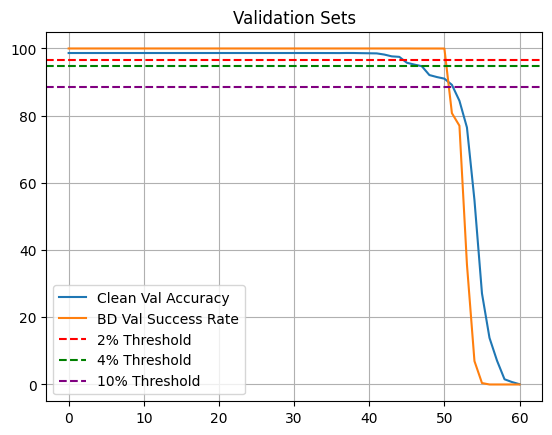

In [7]:
# Plotting the metrics computed on Validation Dataset
x_axis = list(range(len(sorted_mean_activation_inds) + 1))
plt.plot(x_axis, cl_val_accs, label = 'Clean Val Accuracy')
plt.plot(x_axis, bd_val_srs, label = 'BD Val Success Rate')
plt.axhline(max(cl_val_accs) - 2, linestyle='--', label = '2% Threshold', color = 'red')
plt.axhline(max(cl_val_accs) - 4, linestyle='--', label = '4% Threshold', color = 'green')
plt.axhline(max(cl_val_accs) - 10, linestyle='--', label = '10% Threshold', color = 'purple')
plt.legend()
plt.grid()
plt.title('Validation Sets')

Text(0.5, 1.0, 'Test Sets')

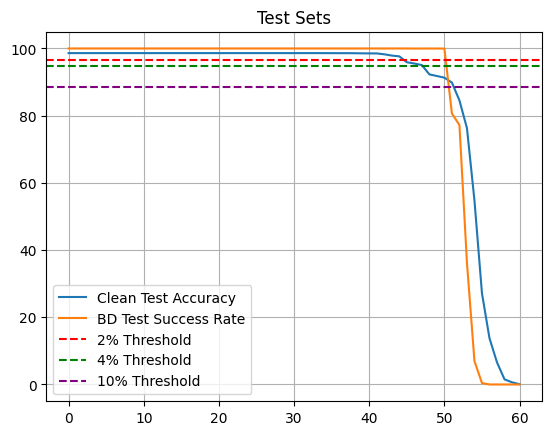

In [8]:
# Plotting the metrics computed on Test Dataset
x_axis = list(range(len(sorted_mean_activation_inds) + 1))
plt.plot(x_axis, cl_test_accs, label = 'Clean Test Accuracy')
plt.plot(x_axis, bd_test_srs, label = 'BD Test Success Rate')
plt.axhline(max(cl_val_accs) - 2, linestyle='--', label = '2% Threshold', color = 'red')
plt.axhline(max(cl_val_accs) - 4, linestyle='--', label = '4% Threshold', color = 'green')
plt.axhline(max(cl_val_accs) - 10, linestyle='--', label = '10% Threshold', color = 'purple')
plt.legend()
plt.grid()
plt.title('Test Sets')

In [9]:
# Defining GoodNet (G) Model which uses both B and B' for prediction. It identifies and labels the detected Bad Samples as n+1 class.
class GoodNet():
    
    # Class Initialization
    def __init__(self, BD_Net_path, num_classes = 1282):
        self.B = keras.models.load_model(BD_Net_path)
        self.B_dash = keras.models.load_model(BD_Net_path)
        self.bd_class = num_classes + 1
    
    # Load Weights Function
    def load_weights(self, B_weights_path, B_dash_weights_path):
        self.B.load_weights(B_weights_path)
        self.B_dash.load_weights(B_dash_weights_path)
    
    # Predict Function 
    def predict(self, X):
        B_pred = np.argmax(self.B.predict(X, verbose = 1), axis=1)
        B_dash_pred = np.argmax(self.B_dash.predict(X, verbose = 1), axis=1)
                
        y_preds = []
        for i in range(len(B_pred)):
            
            # Predict same class if both B and B' predict the same class
            if B_pred[i] == B_dash_pred[i]:
                y_preds.append(B_pred[i])
                
            # Predict N+1 as the class if the predictions from B and B' are different
            else:
                y_preds.append(self.bd_class)
        
        return(y_preds)

In [10]:
B_model_filename = './models/bd_net.h5'
B_model_weights_filename = './models/bd_weights.h5'
clean_data_filename = './data/cl/test.h5'
poisoned_data_filename = './data/bd/bd_test.h5'

# Function to evaluate the created G model
def eval_G(B_dash_model_weights_filename):
    
    # Load the Clean and Bad Test samples
    cl_x_test, cl_y_test = data_loader(clean_data_filename)
    bd_x_test, bd_y_test = data_loader(poisoned_data_filename)
    
    # Initializing GoodNet Model
    G = GoodNet(B_model_filename)
    G.load_weights(B_model_weights_filename, B_dash_model_weights_filename)
    
    # Predict on Clean Set
    cl_test_pred = G.predict(cl_x_test)
    cl_test_acc = np.mean(np.equal(cl_test_pred, cl_y_test))*100
    print('Clean Classification Accuracy:', cl_test_acc)
    
    # Predict on Bad Set
    bd_test_pred = G.predict(bd_x_test)
    bd_test_sr = np.mean(np.equal(bd_test_pred, bd_y_test))*100
    print('Attack Success Rate:', bd_test_sr)
    
    return cl_test_acc, bd_test_sr

In [11]:
# Evaluating G Model using B and 2% B' Models
clean_acc_2p, bad_sr_2p = eval_G('./models/bd_2p_weights.h5')

401/401 [==============================] - 4s 9ms/step
Clean Classification Accuracy: 97.50584567420108
401/401 [==============================] - 4s 9ms/step
Attack Success Rate: 100.0


In [12]:
# Evaluating G Model using B and 4% B' Models
clean_acc_4p, bad_sr_4p = eval_G('./models/bd_4p_weights.h5')

401/401 [==============================] - 4s 9ms/step
Clean Classification Accuracy: 94.90257209664848
401/401 [==============================] - 4s 9ms/step
Attack Success Rate: 99.98441153546376


In [13]:
# Evaluating G Model using B and 10% B' Models
clean_acc_10p, bad_sr_10p = eval_G('./models/bd_10p_weights.h5')

401/401 [==============================] - 4s 9ms/step
Clean Classification Accuracy: 89.68043647700702
401/401 [==============================] - 4s 9ms/step
Attack Success Rate: 80.6469212782541


In [14]:
threshold_metrics = pd.DataFrame()

threshold_metrics['% threshold'] = [2, 4, 10]
threshold_metrics['Clean Acc (%)'] = [clean_acc_2p, clean_acc_4p, clean_acc_10p]
threshold_metrics['Bad SR (%)'] = [bad_sr_2p, bad_sr_4p, bad_sr_10p]

threshold_metrics.to_csv('threshold_metrics.csv')

threshold_metrics

,% threshold,Clean Acc (%),Bad SR (%)
0,2,97.505846,100.000000
1,4,94.902572,99.984412
2,10,89.680436,80.646921


### Generating and storing the Performance Metrics with respect to fraction of channels pruned

In [15]:
num_channels_pruned = list(range(0, 61))
fraction_channels_pruned = [round(channels_pruned*100/60, 5) for channels_pruned in num_channels_pruned]

cl_val_acc_drops = [round(cl_val_accs[0] - cl_val_acc, 5) for cl_val_acc in cl_val_accs]

metrics_df = pd.DataFrame()

metrics_df['Fraction of Channels Pruned (%)'] = fraction_channels_pruned
metrics_df['Val Acc Drop (%)'] = cl_val_acc_drops
metrics_df['Clean Val Acc (%)'] = cl_val_accs
metrics_df['Clean Test Acc (%)'] = cl_test_accs
metrics_df['Bad Val SR (%)'] = bd_val_srs
metrics_df['Bad Test SR (%)'] = bd_test_srs

metrics_df.to_csv('metrics.csv')

metrics_df[metrics_df['Fraction of Channels Pruned (%)'].isin([5.0, 10.0, 20.0, 25.0, 30.0, 40.0, 50.0, 60.0, 70.0, 75.0, 80.0, 90.0, 100.0])]

,Fraction of Channels Pruned (%),Val Acc Drop (%),Clean Val Acc (%),Clean Test Acc (%),Bad Val SR (%),Bad Test SR (%)
3,5.0,0.00000,98.649000,98.620421,100.000000,100.000000
6,10.0,0.00000,98.649000,98.620421,100.000000,100.000000
12,20.0,0.00000,98.649000,98.620421,100.000000,100.000000
15,25.0,0.00000,98.649000,98.620421,100.000000,100.000000
18,30.0,0.00000,98.649000,98.620421,100.000000,100.000000
24,40.0,0.00000,98.649000,98.620421,100.000000,100.000000
30,50.0,0.00000,98.649000,98.620421,100.000000,100.000000
36,60.0,0.01732,98.631679,98.604832,100.000000,100.000000
42,70.0,0.45899,98.190006,98.269680,100.000000,100.000000
45,75.0,2.89253,95.756474,95.900234,100.000000,100.000000
